# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://course.cse.ust.hk/comp4901j/Password_Only/programs/assignment1/index.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


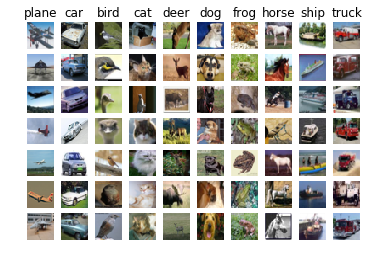

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


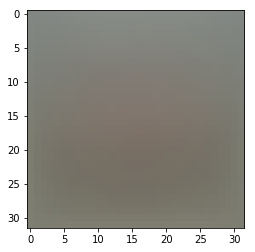

In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [14]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.882100


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [16]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -4.392784 analytic: -4.392784, relative error: 6.683017e-11
numerical: -8.551590 analytic: -8.551590, relative error: 4.107700e-11
numerical: 4.498895 analytic: 4.498895, relative error: 6.195915e-11
numerical: 6.780082 analytic: 6.780082, relative error: 7.363821e-11
numerical: -1.661542 analytic: -1.661542, relative error: 1.256763e-10
numerical: -8.974990 analytic: -8.974990, relative error: 1.044479e-11
numerical: 12.419146 analytic: 12.419146, relative error: 7.314745e-13
numerical: -1.675861 analytic: -1.675861, relative error: 4.755939e-12
numerical: -14.620708 analytic: -14.620708, relative error: 1.451767e-11
numerical: -3.066853 analytic: -3.066853, relative error: 2.293179e-10
numerical: 9.174486 analytic: 9.206729, relative error: 1.754136e-03
numerical: 0.777495 analytic: 0.795861, relative error: 1.167322e-02
numerical: 12.975799 analytic: 12.977110, relative error: 5.051676e-05
numerical: 4.659132 analytic: 4.676177, relative error: 1.825855e-03
numerical: -1.

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** Since SVM loss is hinge loss, it is not a linear function. When j = y_i, the value will be 0.

In [19]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.882100e+00 computed in 0.079000s
Vectorized loss: 8.882100e+00 computed in 0.004998s
difference: 0.000000


In [20]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.077991s
Vectorized loss and gradient: computed in 0.005003s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [22]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 788.107952
iteration 100 / 1500: loss 473.185759
iteration 200 / 1500: loss 287.357263
iteration 300 / 1500: loss 175.199252
iteration 400 / 1500: loss 107.698840
iteration 500 / 1500: loss 66.730896
iteration 600 / 1500: loss 41.951711
iteration 700 / 1500: loss 27.732218
iteration 800 / 1500: loss 18.611325
iteration 900 / 1500: loss 13.148738
iteration 1000 / 1500: loss 10.429289
iteration 1100 / 1500: loss 8.226866
iteration 1200 / 1500: loss 7.459660
iteration 1300 / 1500: loss 6.964219
iteration 1400 / 1500: loss 6.392066
That took 8.540985s


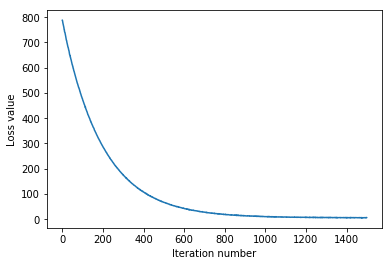

In [23]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [27]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.383000
validation accuracy: 0.386000


In [40]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
range_lr = np.linspace(learning_rates[0], learning_rates[1], num=10, endpoint=True)
range_reg = np.linspace(regularization_strengths[0], regularization_strengths[1], num=50, endpoint=True)

for lr in learning_rates:
    for rs in range_reg:
        svm = LinearSVM()
        _ = svm.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=2000, verbose=True)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        training_accuracy = np.mean(y_train == y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)
                                      
        results[(lr, rs)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 784.000367
iteration 100 / 2000: loss 468.745099
iteration 200 / 2000: loss 284.262364
iteration 300 / 2000: loss 173.040666
iteration 400 / 2000: loss 107.127034
iteration 500 / 2000: loss 66.177339
iteration 600 / 2000: loss 41.629666
iteration 700 / 2000: loss 27.084450
iteration 800 / 2000: loss 18.719537
iteration 900 / 2000: loss 13.687577
iteration 1000 / 2000: loss 10.306701
iteration 1100 / 2000: loss 8.167555
iteration 1200 / 2000: loss 6.898848
iteration 1300 / 2000: loss 6.347507
iteration 1400 / 2000: loss 5.953225
iteration 1500 / 2000: loss 5.666099
iteration 1600 / 2000: loss 5.447388
iteration 1700 / 2000: loss 5.619954
iteration 1800 / 2000: loss 5.102758
iteration 1900 / 2000: loss 5.558937
iteration 0 / 2000: loss 798.681295
iteration 100 / 2000: loss 473.654624
iteration 200 / 2000: loss 284.673043
iteration 300 / 2000: loss 171.546168
iteration 400 / 2000: loss 104.168653
iteration 500 / 2000: loss 64.336374
iteration 600 / 2000: loss 40.6

iteration 100 / 2000: loss 521.035185
iteration 200 / 2000: loss 282.252586
iteration 300 / 2000: loss 154.960489
iteration 400 / 2000: loss 86.134136
iteration 500 / 2000: loss 48.416162
iteration 600 / 2000: loss 28.813265
iteration 700 / 2000: loss 17.993679
iteration 800 / 2000: loss 11.952719
iteration 900 / 2000: loss 9.116335
iteration 1000 / 2000: loss 7.172727
iteration 1100 / 2000: loss 6.851545
iteration 1200 / 2000: loss 6.711614
iteration 1300 / 2000: loss 5.644959
iteration 1400 / 2000: loss 5.712921
iteration 1500 / 2000: loss 5.811938
iteration 1600 / 2000: loss 5.812864
iteration 1700 / 2000: loss 5.002617
iteration 1800 / 2000: loss 5.472563
iteration 1900 / 2000: loss 5.650379
iteration 0 / 2000: loss 986.680146
iteration 100 / 2000: loss 522.036789
iteration 200 / 2000: loss 280.056133
iteration 300 / 2000: loss 152.054448
iteration 400 / 2000: loss 82.560600
iteration 500 / 2000: loss 47.215692
iteration 600 / 2000: loss 27.276883
iteration 700 / 2000: loss 17.2098

iteration 200 / 2000: loss 259.070277
iteration 300 / 2000: loss 127.837386
iteration 400 / 2000: loss 64.047638
iteration 500 / 2000: loss 33.926789
iteration 600 / 2000: loss 19.198607
iteration 700 / 2000: loss 12.827592
iteration 800 / 2000: loss 8.668195
iteration 900 / 2000: loss 7.086622
iteration 1000 / 2000: loss 6.456615
iteration 1100 / 2000: loss 6.216327
iteration 1200 / 2000: loss 5.965974
iteration 1300 / 2000: loss 5.775364
iteration 1400 / 2000: loss 5.968043
iteration 1500 / 2000: loss 5.305001
iteration 1600 / 2000: loss 5.342852
iteration 1700 / 2000: loss 4.959013
iteration 1800 / 2000: loss 6.104373
iteration 1900 / 2000: loss 6.057581
iteration 0 / 2000: loss 1152.658416
iteration 100 / 2000: loss 547.095996
iteration 200 / 2000: loss 262.665223
iteration 300 / 2000: loss 128.033516
iteration 400 / 2000: loss 63.672485
iteration 500 / 2000: loss 33.060986
iteration 600 / 2000: loss 18.574948
iteration 700 / 2000: loss 12.015567
iteration 800 / 2000: loss 8.297393

iteration 400 / 2000: loss 49.432368
iteration 500 / 2000: loss 24.473772
iteration 600 / 2000: loss 13.679478
iteration 700 / 2000: loss 9.159979
iteration 800 / 2000: loss 7.424338
iteration 900 / 2000: loss 5.919487
iteration 1000 / 2000: loss 6.510263
iteration 1100 / 2000: loss 5.627691
iteration 1200 / 2000: loss 5.434544
iteration 1300 / 2000: loss 5.988609
iteration 1400 / 2000: loss 5.064728
iteration 1500 / 2000: loss 5.535025
iteration 1600 / 2000: loss 5.469547
iteration 1700 / 2000: loss 5.151533
iteration 1800 / 2000: loss 5.638931
iteration 1900 / 2000: loss 5.477580
iteration 0 / 2000: loss 1320.091165
iteration 100 / 2000: loss 557.835461
iteration 200 / 2000: loss 240.165923
iteration 300 / 2000: loss 105.843364
iteration 400 / 2000: loss 47.979944
iteration 500 / 2000: loss 23.374429
iteration 600 / 2000: loss 13.536401
iteration 700 / 2000: loss 8.760005
iteration 800 / 2000: loss 7.709048
iteration 900 / 2000: loss 5.999906
iteration 1000 / 2000: loss 5.407980
iter

iteration 600 / 2000: loss 10.803643
iteration 700 / 2000: loss 7.724100
iteration 800 / 2000: loss 6.703078
iteration 900 / 2000: loss 6.082886
iteration 1000 / 2000: loss 6.014346
iteration 1100 / 2000: loss 5.917968
iteration 1200 / 2000: loss 5.554079
iteration 1300 / 2000: loss 5.617534
iteration 1400 / 2000: loss 5.651794
iteration 1500 / 2000: loss 5.687759
iteration 1600 / 2000: loss 5.951797
iteration 1700 / 2000: loss 5.851509
iteration 1800 / 2000: loss 5.826948
iteration 1900 / 2000: loss 5.734433
iteration 0 / 2000: loss 1504.264264
iteration 100 / 2000: loss 568.657488
iteration 200 / 2000: loss 219.090964
iteration 300 / 2000: loss 86.883556
iteration 400 / 2000: loss 36.373389
iteration 500 / 2000: loss 17.482150
iteration 600 / 2000: loss 10.538769
iteration 700 / 2000: loss 7.689232
iteration 800 / 2000: loss 6.715004
iteration 900 / 2000: loss 6.108162
iteration 1000 / 2000: loss 5.293519
iteration 1100 / 2000: loss 5.801674
iteration 1200 / 2000: loss 5.274504
itera

iteration 200 / 2000: loss 2094.016269
iteration 300 / 2000: loss 2037.198236
iteration 400 / 2000: loss 2094.496084
iteration 500 / 2000: loss 2089.053993
iteration 600 / 2000: loss 2397.888405
iteration 700 / 2000: loss 2439.341068
iteration 800 / 2000: loss 2305.963690
iteration 900 / 2000: loss 2800.304353
iteration 1000 / 2000: loss 2213.223725
iteration 1100 / 2000: loss 2296.407617
iteration 1200 / 2000: loss 2153.615713
iteration 1300 / 2000: loss 2694.170818
iteration 1400 / 2000: loss 2423.435601
iteration 1500 / 2000: loss 2594.274210
iteration 1600 / 2000: loss 2421.571464
iteration 1700 / 2000: loss 2170.989175
iteration 1800 / 2000: loss 2461.803606
iteration 1900 / 2000: loss 2428.334366
iteration 0 / 2000: loss 874.124959
iteration 100 / 2000: loss 2761.875206
iteration 200 / 2000: loss 2698.591902
iteration 300 / 2000: loss 2814.807166
iteration 400 / 2000: loss 2562.792371
iteration 500 / 2000: loss 2559.809727
iteration 600 / 2000: loss 2152.397113
iteration 700 / 20

iteration 1100 / 2000: loss 5855.451638
iteration 1200 / 2000: loss 5547.342046
iteration 1300 / 2000: loss 5753.581341
iteration 1400 / 2000: loss 5448.880440
iteration 1500 / 2000: loss 6365.884432
iteration 1600 / 2000: loss 5863.770883
iteration 1700 / 2000: loss 5551.509484
iteration 1800 / 2000: loss 6823.108264
iteration 1900 / 2000: loss 5918.891803
iteration 0 / 2000: loss 1052.335866
iteration 100 / 2000: loss 7639.941136
iteration 200 / 2000: loss 8323.276429
iteration 300 / 2000: loss 7290.181602
iteration 400 / 2000: loss 7774.218005
iteration 500 / 2000: loss 7708.826631
iteration 600 / 2000: loss 6907.498799
iteration 700 / 2000: loss 7534.619317
iteration 800 / 2000: loss 7819.529719
iteration 900 / 2000: loss 7385.097260
iteration 1000 / 2000: loss 7729.208791
iteration 1100 / 2000: loss 6835.726887
iteration 1200 / 2000: loss 7864.388140
iteration 1300 / 2000: loss 8462.709345
iteration 1400 / 2000: loss 6729.178918
iteration 1500 / 2000: loss 6855.865147
iteration 16

iteration 1600 / 2000: loss 69305.774849
iteration 1700 / 2000: loss 69367.826054
iteration 1800 / 2000: loss 63616.283837
iteration 1900 / 2000: loss 67690.291746
iteration 0 / 2000: loss 1188.768877
iteration 100 / 2000: loss 107496.606822
iteration 200 / 2000: loss 112676.333576
iteration 300 / 2000: loss 106804.258742
iteration 400 / 2000: loss 116847.376065
iteration 500 / 2000: loss 110906.839392
iteration 600 / 2000: loss 108299.586037
iteration 700 / 2000: loss 105870.048955
iteration 800 / 2000: loss 112313.148812
iteration 900 / 2000: loss 111488.488782
iteration 1000 / 2000: loss 116759.720235
iteration 1100 / 2000: loss 111717.294040
iteration 1200 / 2000: loss 117984.231328
iteration 1300 / 2000: loss 106109.895552
iteration 1400 / 2000: loss 113103.843021
iteration 1500 / 2000: loss 114971.694192
iteration 1600 / 2000: loss 108941.818413
iteration 1700 / 2000: loss 106383.824085
iteration 1800 / 2000: loss 109771.046846
iteration 1900 / 2000: loss 105665.237775
iteration 

iteration 500 / 2000: loss 13917442448011521172862719611215061454946304.000000
iteration 600 / 2000: loss 595799085963537349049565263271701738709650006605824.000000
iteration 700 / 2000: loss 25505875246906769337223568888067675540236501388648953937920.000000
iteration 800 / 2000: loss 1091894377546233799362348697606771317573278011398143523933543989248.000000
iteration 900 / 2000: loss 46743478519195902083694620119921463166562563175972435246403380318608293888.000000
iteration 1000 / 2000: loss 2001066063720080226880027576417314748998786938327734211873009669064944818875006976.000000
iteration 1100 / 2000: loss 85664685603741797369445853351735616364942090214220034912060621226417711381716955958345728.000000
iteration 1200 / 2000: loss 3667264411023697507083703114019342932572744912383623135760305594457623001507748831833995266228224.000000
iteration 1300 / 2000: loss 156993843677557910952225928414769620903838160540620984912004579431405962722196647169461405780931963256832.000000
iteration 140

iteration 700 / 2000: loss 1291707196889874111146604547896583435229793374294679420409182884813648011191410724559210681710149632.000000
iteration 800 / 2000: loss 42368810947535281064098443085562728611981134539486957402092510012132882008161570894453009261328135193290591961088.000000
iteration 900 / 2000: loss 1389723727970395763793995206073620927766016210094700355091476548851321490622244218628381869224229214514165622870239076692262912.000000
iteration 1000 / 2000: loss 45583815001923852040070494310315801187963636901175734943346147097802381207098202874527233001763417273362369115583977633301470298661965529088.000000
iteration 1100 / 2000: loss 1495177889179626833674751296592344193558877950830112685778743826499937396912277979573354965457983713779571208059849570803554479110544752562398331179892736.000000
iteration 1200 / 2000: loss 49042778016655530078563214034695126859020927048476316708714715940472089925411208651476069780808095504267890968951855967090924126506074444174178357787550915087040

D:\HKUST\COMP4471\WPy-3662\notebooks\assignment1\cs231n\classifiers\linear_svm.py:86: RuntimeWarning: overflow encountered in double_scalars
  loss += reg* np.sum(W * W)


iteration 0 / 2000: loss 1396.835312
iteration 100 / 2000: loss 3202991146068948287488.000000
iteration 200 / 2000: loss 541903128680890051180340757495365500928.000000
iteration 300 / 2000: loss 91682738470609829013004471133467335219361518102494838784.000000
iteration 400 / 2000: loss 15511489210131701518638334662672090664692435245256311016683767479245209600.000000
iteration 500 / 2000: loss 2624335851324532547134112961452327544447588496106362744550102549384310266301163209679175680.000000
iteration 600 / 2000: loss 444002414419935687981151948568179138798837950387603487715415495236153751896724728689049622155158616786599936.000000
iteration 700 / 2000: loss 75119251185489237499180853393053696057839474718154024871017399556298102774052070868843229462615535873889698100422558229725184.000000
iteration 800 / 2000: loss 12709169399542033604067787798303067080772186966825339178797518529833106382993273768266512290668699733677819712215113347822568774881731841884160.000000
iteration 900 / 2000: los

D:\HKUST\COMP4471\WPy-3662\python-3.6.6.amd64\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
D:\HKUST\COMP4471\WPy-3662\notebooks\assignment1\cs231n\classifiers\linear_svm.py:86: RuntimeWarning: overflow encountered in multiply
  loss += reg* np.sum(W * W)


iteration 1800 / 2000: loss inf
iteration 1900 / 2000: loss inf
iteration 0 / 2000: loss 1409.424528
iteration 100 / 2000: loss 156225114659459734437888.000000
iteration 200 / 2000: loss 1661505750693172303110847671138508133629952.000000
iteration 300 / 2000: loss 17670663030852675646005846258501254835787765584411818316529664.000000
iteration 400 / 2000: loss 187933344088441152030677714176117696954098219151000720664459498295344775242448896.000000
iteration 500 / 2000: loss 1998733254015320942041210421169732216447246745197494376644695657623994252379223022551228053331116032.000000
iteration 600 / 2000: loss 21257189032014790147436084892972519492921068208878696168077812972357918758678117486036490083204068042438173205150564352.000000
iteration 700 / 2000: loss 226077233985594319481367707260106202602931325986589438002973707717880297336519693498723589209720071441556968839752512980201135133853483008.000000
iteration 800 / 2000: loss 240440613524208694758041409581266690265416833588866204048041

iteration 1300 / 2000: loss 527610840287572874091495664217435824045071012251430211039171294450525058371283884717721703287444207143942745108484779658002381587078958757476494605693199709588882919768769376057787837665516255026241463880107134163762716366688095087076820260788563972710149022526072418352570750516202167393717321728.000000
iteration 1400 / 2000: loss inf
iteration 1500 / 2000: loss inf
iteration 1600 / 2000: loss inf
iteration 1700 / 2000: loss inf
iteration 1800 / 2000: loss inf
iteration 1900 / 2000: loss inf
iteration 0 / 2000: loss 1449.595357
iteration 100 / 2000: loss 15830495615340735139382558720.000000
iteration 200 / 2000: loss 25599592770686966428700683115130324714605900625608704.000000
iteration 300 / 2000: loss 41397260448945391921445498597530718278538622603608343057619601195164967632896.000000
iteration 400 / 2000: loss 66943766958673771366754063555742135931427763492694391745533311654182892307946524914925059498756276224.000000
iteration 500 / 2000: loss 10825518128

iteration 200 / 2000: loss 107942958707469882965488315297243767864237837970008190700486656.000000
iteration 300 / 2000: loss 13554784290444371395840151489457395740209826073894118204470008617981735622321096505293799424.000000
iteration 400 / 2000: loss 1702122856002120510507821281306519200020049639152796237531522325405356346379656832234269423093058256122176406036810825728.000000
iteration 500 / 2000: loss 213741668981575104507062149498968068520932549051692658835452284558472957067185264359330395485543991888408560231246360009488329329689038306456683675648.000000
iteration 600 / 2000: loss 26840307618178351898929250729073731699373165574867804330897751254193815499465183047190918958833545923096256002354892803754207883572258358203130132555591574465417781099552743358464.000000
iteration 700 / 2000: loss 3370433647640989741975527238497832283607374213656575104506402558717895998193639727032233687568505176130686967033858961491920520545648739525599647281899564368271718222265111358034772162498773902

D:\HKUST\COMP4471\WPy-3662\notebooks\assignment1\cs231n\classifiers\linear_svm.py:82: RuntimeWarning: overflow encountered in subtract
  margin = scores - scores[np.arange(num_train), y].reshape(num_train, 1) + 1
D:\HKUST\COMP4471\WPy-3662\notebooks\assignment1\cs231n\classifiers\linear_svm.py:84: RuntimeWarning: invalid value encountered in multiply
  margin = (margin > 0) * margin
D:\HKUST\COMP4471\WPy-3662\notebooks\assignment1\cs231n\classifiers\linear_svm.py:101: RuntimeWarning: invalid value encountered in greater
  margin = (margin > 0) * 1
D:\HKUST\COMP4471\WPy-3662\notebooks\assignment1\cs231n\classifiers\linear_svm.py:82: RuntimeWarning: invalid value encountered in subtract
  margin = scores - scores[np.arange(num_train), y].reshape(num_train, 1) + 1
D:\HKUST\COMP4471\WPy-3662\notebooks\assignment1\cs231n\classifiers\linear_svm.py:84: RuntimeWarning: invalid value encountered in greater
  margin = (margin > 0) * margin
D:\HKUST\COMP4471\WPy-3662\notebooks\assignment1\cs231n\

iteration 0 / 2000: loss 1526.189406
iteration 100 / 2000: loss 867135046466884526825195239722975232.000000
iteration 200 / 2000: loss 141429653481391212215552997315776067443688789061119086512098961784832.000000
iteration 300 / 2000: loss 23067164642191949625215122970766669454046150972318211842270250427906065772015386374446767898911309824.000000
iteration 400 / 2000: loss 3762252621936893931318630558473788879233475011153646071508156870140187477257045016668657024912452596880357415936571440032147541327872.000000
iteration 500 / 2000: loss 613623087658596783965340123002232614506365639496527812112556903637043202024663519263103765714372904177889640214595145412318084473376525800523101744405166042751434752.000000
iteration 600 / 2000: loss 100081874224017936243129479590363510501039546057860325759479687416825555439284235806380554029579376155754519111495929497223058551914796380910716219406451048870095427747663721307748185155159208230912.000000
iteration 700 / 2000: loss 163233453069891475390478

In [41]:
JJresults

{(1e-07, 25000.0): (0.38026530612244897, 0.386),
 (1e-07, 25510.20408163265): (0.38146938775510203, 0.384),
 (1e-07, 26020.408163265307): (0.3813469387755102, 0.401),
 (1e-07, 26530.61224489796): (0.3790204081632653, 0.389),
 (1e-07, 27040.816326530614): (0.38218367346938775, 0.393),
 (1e-07, 27551.020408163266): (0.38424489795918365, 0.386),
 (1e-07, 28061.224489795917): (0.3773061224489796, 0.389),
 (1e-07, 28571.428571428572): (0.3830612244897959, 0.388),
 (1e-07, 29081.632653061224): (0.37855102040816324, 0.398),
 (1e-07, 29591.836734693876): (0.3798979591836735, 0.372),
 (1e-07, 30102.04081632653): (0.375530612244898, 0.381),
 (1e-07, 30612.244897959183): (0.3750816326530612, 0.38),
 (1e-07, 31122.448979591838): (0.3806326530612245, 0.375),
 (1e-07, 31632.65306122449): (0.37687755102040815, 0.381),
 (1e-07, 32142.857142857145): (0.37583673469387757, 0.385),
 (1e-07, 32653.061224489797): (0.37910204081632654, 0.389),
 (1e-07, 33163.26530612245): (0.37812244897959185, 0.387),
 (1e-0

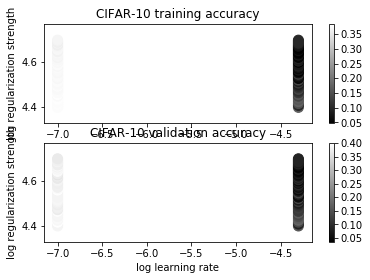

In [42]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [43]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.375000


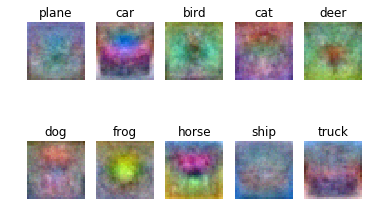

In [44]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** The images retain some of the feature of the class. Because if there is a huge difference in the weighted image, the loss will be large. The gradient will try to minimize the loss and tends to look like the original image.